# H&M Transactions Data - Exploratory Data Analysis

This notebook performs comprehensive EDA on the cleaned transactions dataset to understand:
- Transaction patterns and trends over time
- Price distributions and purchasing behaviour
- Customer transaction frequency patterns
- Seasonal and temporal trends
- Revenue insights and business metrics

## 1. Setup and Data Loading

In [1]:
# Import required libraries
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Add project root to path
import sys
project_root = Path.cwd().parent.parent  # Go up two levels from notebooks/eda_notebooks/
sys.path.append(str(project_root))

try:
    from hnm_data_analysis.exploratory_data_analysis.eda_module import EDAModule
    print("✅ EDA module imported successfully")
except ImportError as e:
    print(f"⚠️ Could not import EDA module: {e}")
    print("Continuing without EDA module...")

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100
warnings.filterwarnings('ignore')

print("📦 Libraries imported successfully")

✅ EDA module imported successfully
📦 Libraries imported successfully


In [2]:
# Load transactions data
data_path = "../../data/cleaned/transactions_cleaned.parquet"
print(f"Loading data from: {data_path}")

try:
    df = pl.read_parquet(data_path)
    print(f"✅ Data loaded successfully: {df.shape[0]:,} rows × {df.shape[1]} columns")
    print(f"Memory usage: {df.estimated_size('mb'):.1f} MB")
except Exception as e:
    print(f"❌ Error loading data: {e}")
    raise

Loading data from: ../../data/cleaned/transactions_cleaned.parquet
✅ Data loaded successfully: 3,904,391 rows × 8 columns
Memory usage: 344.0 MB


## 2. Initial Data Exploration

In [3]:
# Display basic information about the dataset
print("📊 Dataset Overview")
print("=" * 50)
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns}")
print(f"Data types: {dict(zip(df.columns, df.dtypes))}")

# Display first few rows
print("\n🔍 First 5 rows:")
df.head()

📊 Dataset Overview
Shape: (3904391, 8)
Columns: ['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id', 'price_outlier_capped', 'sales_channel_corrected', 'price_percentile_calibrated']
Data types: {'t_dat': Date, 'customer_id': String, 'article_id': Int64, 'price': Float64, 'sales_channel_id': Int64, 'price_outlier_capped': Boolean, 'sales_channel_corrected': Boolean, 'price_percentile_calibrated': Boolean}

🔍 First 5 rows:


t_dat,customer_id,article_id,price,sales_channel_id,price_outlier_capped,sales_channel_corrected,price_percentile_calibrated
date,str,i64,f64,i64,bool,bool,bool
2020-06-24,"""0001b0127d3e5ff8dadcfc6e504368…",844409002,14.33,1,false,false,true
2020-06-24,"""0001b0127d3e5ff8dadcfc6e504368…",876053003,21.35,1,false,false,true
2020-06-24,"""000493dd9fc463df1acc2081450c9e…",831269004,11.32,1,false,false,true
2020-06-24,"""000493dd9fc463df1acc2081450c9e…",886223001,41.99,1,false,false,true
2020-06-24,"""000493dd9fc463df1acc2081450c9e…",868955003,16.01,1,false,false,true


In [4]:
# Check for missing values and data quality
print("🔍 Data Quality Assessment")
print("=" * 40)

missing_summary = []
for col in df.columns:
    null_count = df.select(pl.col(col).null_count()).item()
    null_pct = (null_count / df.height) * 100
    missing_summary.append({
        'Column': col,
        'Missing Count': null_count,
        'Missing %': f"{null_pct:.2f}%"
    })

missing_df = pd.DataFrame(missing_summary)
print(missing_df.to_string(index=False))

# Check for duplicates
duplicate_count = df.height - df.n_unique()
print(f"\n🔄 Duplicate rows: {duplicate_count:,}")

🔍 Data Quality Assessment
                     Column  Missing Count Missing %
                      t_dat              0     0.00%
                customer_id              0     0.00%
                 article_id              0     0.00%
                      price              0     0.00%
           sales_channel_id              0     0.00%
       price_outlier_capped              0     0.00%
    sales_channel_corrected              0     0.00%
price_percentile_calibrated              0     0.00%

🔄 Duplicate rows: 328,885


In [5]:
# Basic descriptive statistics
print("📈 Descriptive Statistics")
print("=" * 40)

# Get numeric columns
numeric_cols = df.select(pl.col(pl.NUMERIC_DTYPES)).columns
print(f"Numeric columns: {numeric_cols}")

if 'price' in df.columns:
    price_stats = df.select([
        pl.col('price').count().alias('count'),
        pl.col('price').mean().alias('mean'),
        pl.col('price').median().alias('median'),
        pl.col('price').std().alias('std'),
        pl.col('price').min().alias('min'),
        pl.col('price').max().alias('max'),
        pl.col('price').quantile(0.25).alias('Q1'),
        pl.col('price').quantile(0.75).alias('Q3')
    ])
    
    print("\n💰 Price Statistics:")
    for col in price_stats.columns:
        value = price_stats.select(col).item()
        print(f"{col}: £{value:.2f}" if col != 'count' else f"{col}: {value:,}")

📈 Descriptive Statistics
Numeric columns: ['article_id', 'price', 'sales_channel_id']

💰 Price Statistics:
count: 3,904,391
mean: £26.84
median: £19.99
std: £28.50
min: £2.39
max: £149.99
Q1: £12.99
Q3: £29.99


## 3. Transaction Volume Analysis

📅 Transaction Volume Analysis
Date range: 2020-06-24 to 2020-09-22
Total days: 91


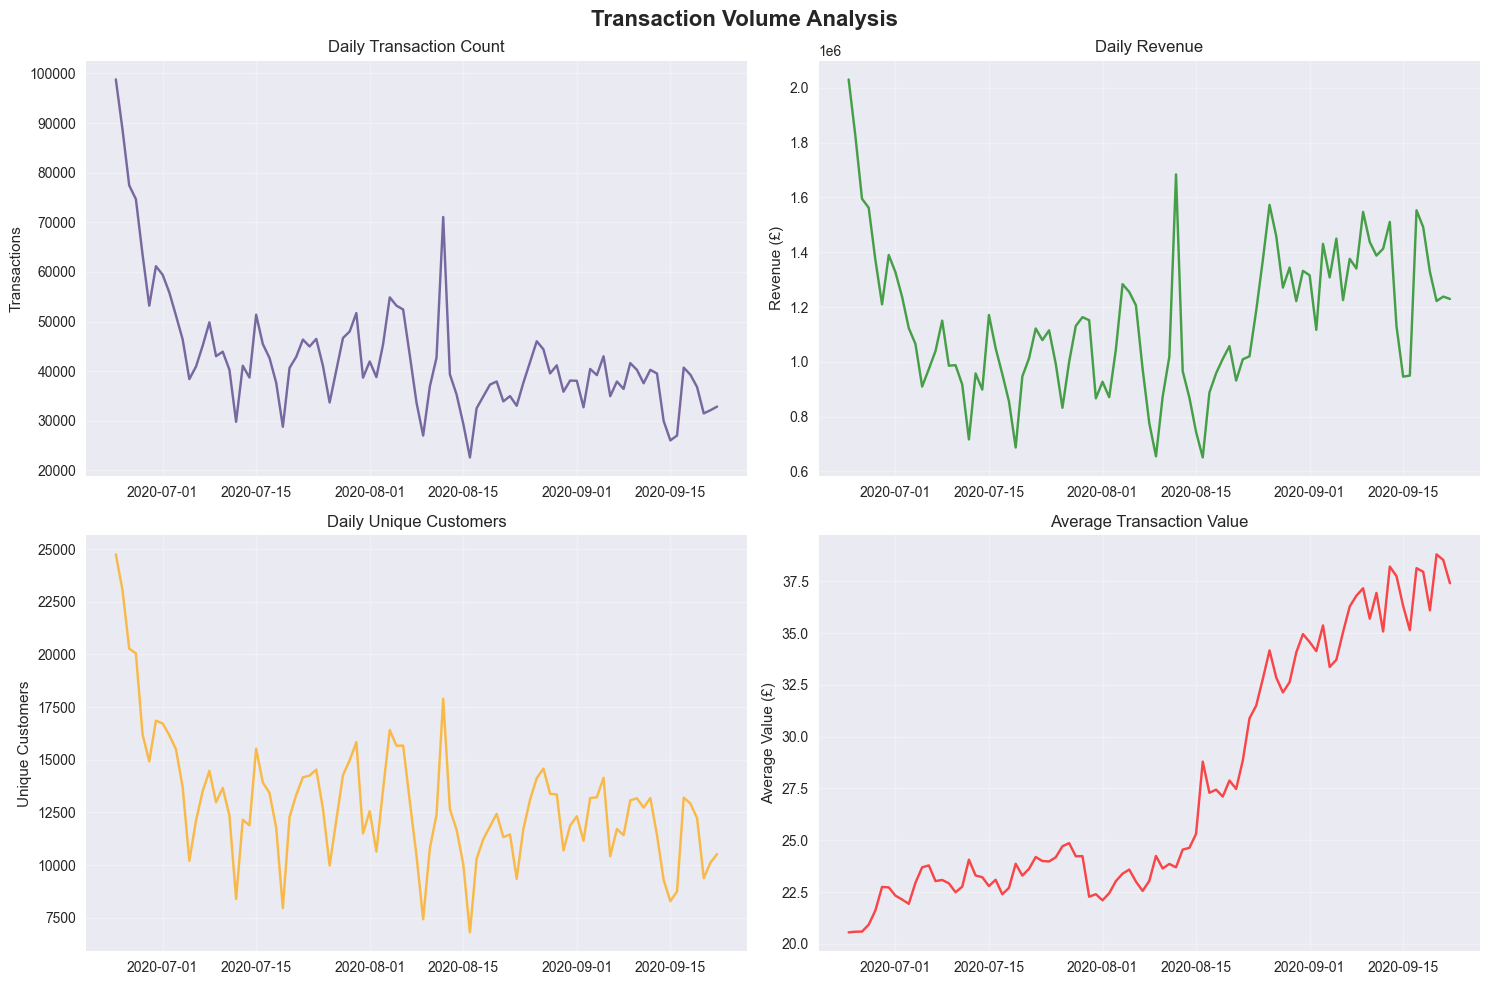

In [6]:
# Transaction volume over time
print("📅 Transaction Volume Analysis")

# Daily transaction counts
daily_transactions = (
    df.group_by('t_dat')
    .agg([
        pl.len().alias('transaction_count'),
        pl.col('price').sum().alias('daily_revenue'),
        pl.col('customer_id').n_unique().alias('unique_customers')
    ])
    .sort('t_dat')
)

print(f"Date range: {daily_transactions.select(pl.col('t_dat').min()).item()} to {daily_transactions.select(pl.col('t_dat').max()).item()}")
print(f"Total days: {daily_transactions.height:,}")

# Convert to pandas for plotting
daily_pd = daily_transactions.to_pandas()
daily_pd['t_dat'] = pd.to_datetime(daily_pd['t_dat'])

# Create transaction volume plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Transaction Volume Analysis', fontsize=16, fontweight='bold')

# Daily transaction count
axes[0, 0].plot(daily_pd['t_dat'], daily_pd['transaction_count'], alpha=0.7)
axes[0, 0].set_title('Daily Transaction Count')
axes[0, 0].set_ylabel('Transactions')
axes[0, 0].grid(True, alpha=0.3)

# Daily revenue
axes[0, 1].plot(daily_pd['t_dat'], daily_pd['daily_revenue'], color='green', alpha=0.7)
axes[0, 1].set_title('Daily Revenue')
axes[0, 1].set_ylabel('Revenue (£)')
axes[0, 1].grid(True, alpha=0.3)

# Daily unique customers
axes[1, 0].plot(daily_pd['t_dat'], daily_pd['unique_customers'], color='orange', alpha=0.7)
axes[1, 0].set_title('Daily Unique Customers')
axes[1, 0].set_ylabel('Unique Customers')
axes[1, 0].grid(True, alpha=0.3)

# Average transaction value
daily_pd['avg_transaction_value'] = daily_pd['daily_revenue'] / daily_pd['transaction_count']
axes[1, 1].plot(daily_pd['t_dat'], daily_pd['avg_transaction_value'], color='red', alpha=0.7)
axes[1, 1].set_title('Average Transaction Value')
axes[1, 1].set_ylabel('Average Value (£)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Price Distribution Analysis

💰 Price Distribution Analysis


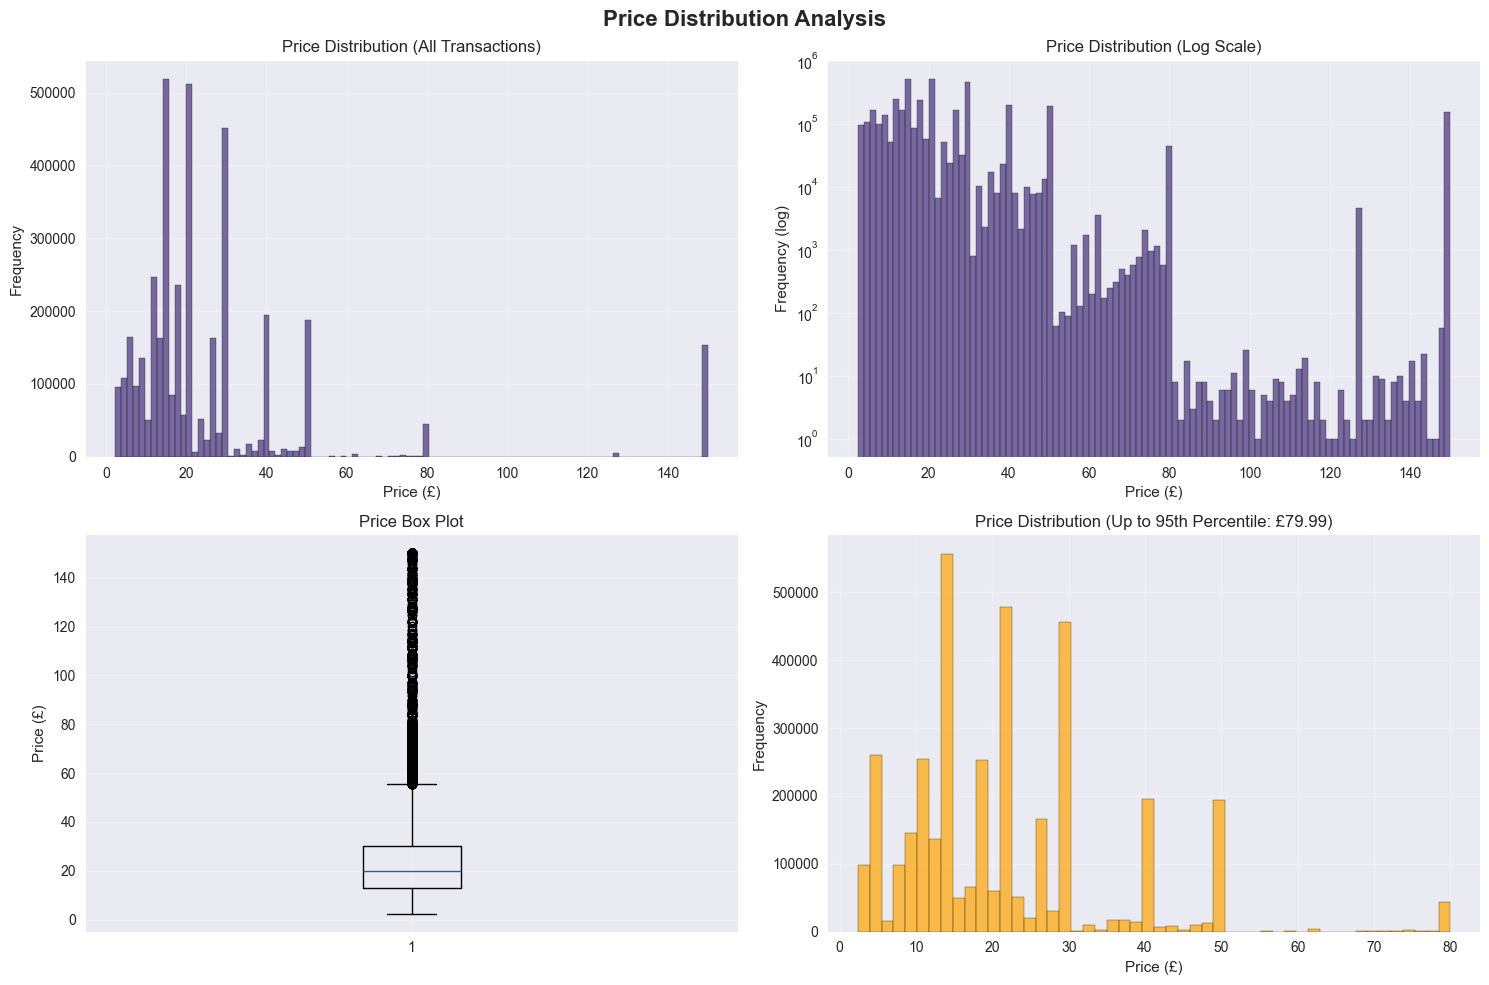


📊 Price Quantiles:
10th percentile: £7.99
25th percentile: £12.99
50th percentile: £19.99
75th percentile: £29.99
90th percentile: £49.99
95th percentile: £79.99
99th percentile: £149.99


In [7]:
# Price distribution analysis
print("💰 Price Distribution Analysis")

# Create comprehensive price distribution plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Price Distribution Analysis', fontsize=16, fontweight='bold')

# Convert price to pandas for plotting
price_data = df.select('price').to_pandas()['price'].dropna()

# Histogram
axes[0, 0].hist(price_data, bins=100, alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Price Distribution (All Transactions)')
axes[0, 0].set_xlabel('Price (£)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

# Log-scale histogram for better visibility
axes[0, 1].hist(price_data, bins=100, alpha=0.7, edgecolor='black')
axes[0, 1].set_yscale('log')
axes[0, 1].set_title('Price Distribution (Log Scale)')
axes[0, 1].set_xlabel('Price (£)')
axes[0, 1].set_ylabel('Frequency (log)')
axes[0, 1].grid(True, alpha=0.3)

# Box plot
axes[1, 0].boxplot(price_data, vert=True)
axes[1, 0].set_title('Price Box Plot')
axes[1, 0].set_ylabel('Price (£)')
axes[1, 0].grid(True, alpha=0.3)

# Price distribution for reasonable range (remove extreme outliers for visibility)
price_95th = np.percentile(price_data, 95)
price_filtered = price_data[price_data <= price_95th]
axes[1, 1].hist(price_filtered, bins=50, alpha=0.7, edgecolor='black', color='orange')
axes[1, 1].set_title(f'Price Distribution (Up to 95th Percentile: £{price_95th:.2f})')
axes[1, 1].set_xlabel('Price (£)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Price quantiles
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
price_quantiles = {}
for q in quantiles:
    price_quantiles[f'{int(q*100)}th percentile'] = df.select(pl.col('price').quantile(q)).item()

print("\n📊 Price Quantiles:")
for k, v in price_quantiles.items():
    print(f"{k}: £{v:.2f}")

## 5. Customer Behaviour Analysis

👥 Customer Transaction Behaviour
Total unique customers: 525,075

📊 Customer Transaction Statistics:
avg_transactions: 7.4
median_transactions: 5.0
max_transactions: 350.0
avg_total_spend: £199.57
median_total_spend: £104.92


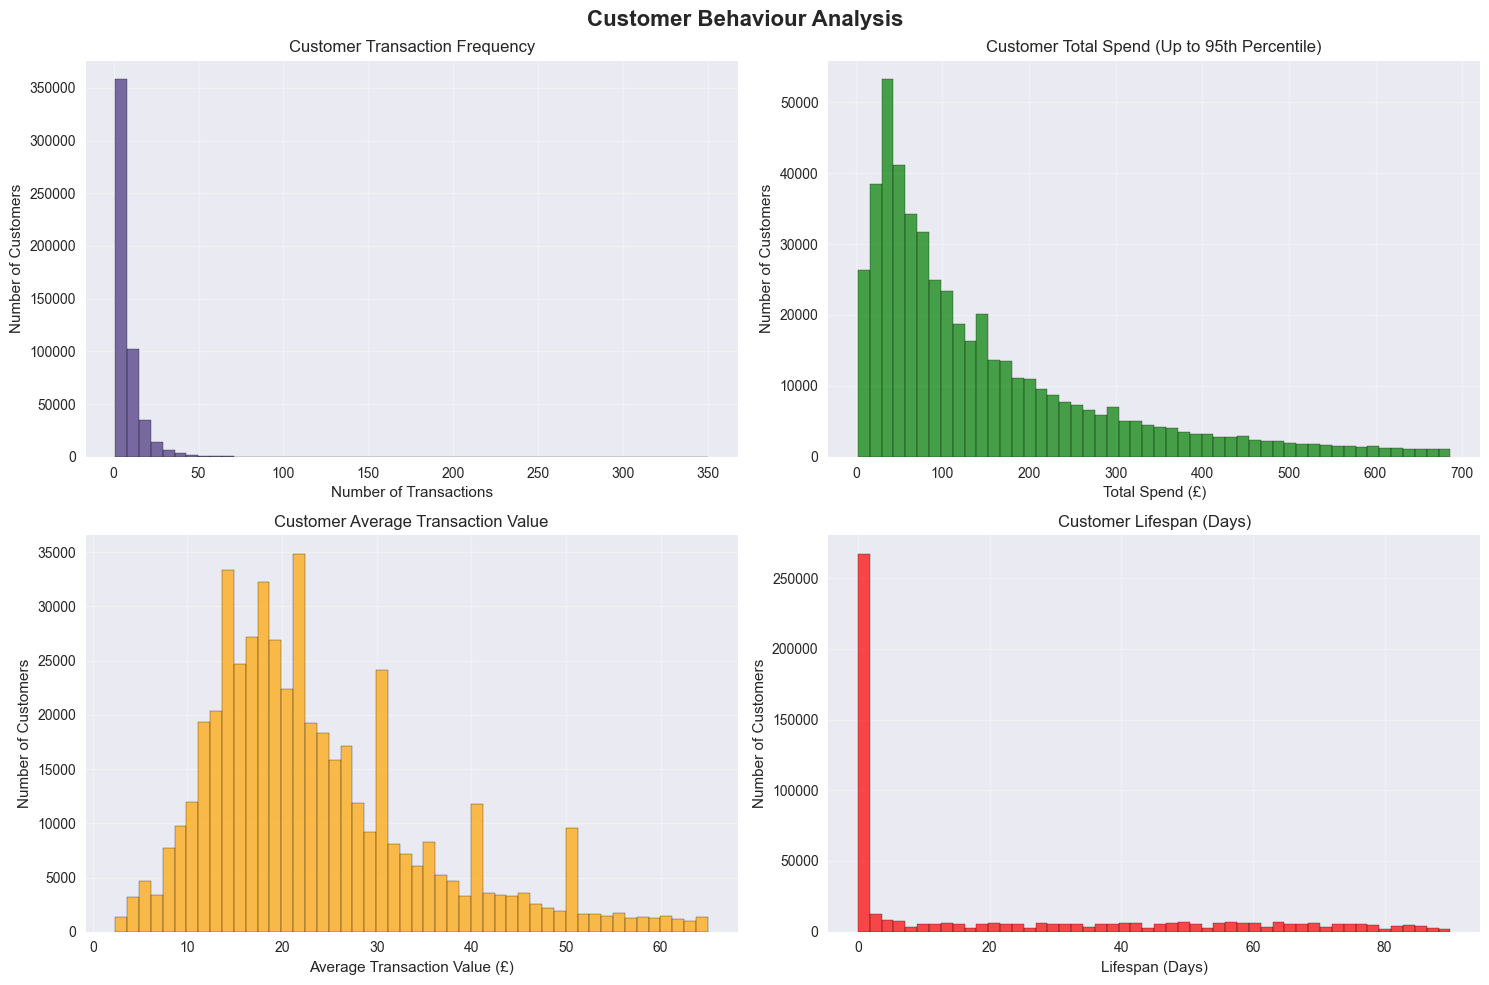

In [8]:
# Customer transaction frequency analysis
print("👥 Customer Transaction Behaviour")

# Customer transaction frequency
customer_freq = (
    df.group_by('customer_id')
    .agg([
        pl.len().alias('transaction_count'),
        pl.col('price').sum().alias('total_spend'),
        pl.col('price').mean().alias('avg_transaction_value'),
        pl.col('t_dat').min().alias('first_purchase'),
        pl.col('t_dat').max().alias('last_purchase')
    ])
    .with_columns([
        (pl.col('last_purchase') - pl.col('first_purchase')).dt.total_days().alias('customer_lifespan_days')
    ])
)

print(f"Total unique customers: {customer_freq.height:,}")

# Customer frequency distribution
freq_stats = customer_freq.select([
    pl.col('transaction_count').mean().alias('avg_transactions'),
    pl.col('transaction_count').median().alias('median_transactions'),
    pl.col('transaction_count').max().alias('max_transactions'),
    pl.col('total_spend').mean().alias('avg_total_spend'),
    pl.col('total_spend').median().alias('median_total_spend')
]).to_dict(as_series=False)

print("\n📊 Customer Transaction Statistics:")
for k, v in freq_stats.items():
    if 'spend' in k:
        print(f"{k}: £{v[0]:.2f}")
    else:
        print(f"{k}: {v[0]:.1f}")

# Plot customer behaviour
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Customer Behaviour Analysis', fontsize=16, fontweight='bold')

# Convert to pandas for plotting
customer_pd = customer_freq.to_pandas()

# Transaction frequency distribution
axes[0, 0].hist(customer_pd['transaction_count'], bins=50, alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Customer Transaction Frequency')
axes[0, 0].set_xlabel('Number of Transactions')
axes[0, 0].set_ylabel('Number of Customers')
axes[0, 0].grid(True, alpha=0.3)

# Total spend distribution
spend_95th = customer_pd['total_spend'].quantile(0.95)
spend_filtered = customer_pd[customer_pd['total_spend'] <= spend_95th]['total_spend']
axes[0, 1].hist(spend_filtered, bins=50, alpha=0.7, edgecolor='black', color='green')
axes[0, 1].set_title(f'Customer Total Spend (Up to 95th Percentile)')
axes[0, 1].set_xlabel('Total Spend (£)')
axes[0, 1].set_ylabel('Number of Customers')
axes[0, 1].grid(True, alpha=0.3)

# Average transaction value
avg_val_95th = customer_pd['avg_transaction_value'].quantile(0.95)
avg_val_filtered = customer_pd[customer_pd['avg_transaction_value'] <= avg_val_95th]['avg_transaction_value']
axes[1, 0].hist(avg_val_filtered, bins=50, alpha=0.7, edgecolor='black', color='orange')
axes[1, 0].set_title('Customer Average Transaction Value')
axes[1, 0].set_xlabel('Average Transaction Value (£)')
axes[1, 0].set_ylabel('Number of Customers')
axes[1, 0].grid(True, alpha=0.3)

# Customer lifespan
lifespan_filtered = customer_pd[customer_pd['customer_lifespan_days'] >= 0]['customer_lifespan_days']
axes[1, 1].hist(lifespan_filtered, bins=50, alpha=0.7, edgecolor='black', color='red')
axes[1, 1].set_title('Customer Lifespan (Days)')
axes[1, 1].set_xlabel('Lifespan (Days)')
axes[1, 1].set_ylabel('Number of Customers')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Temporal Patterns and Seasonality

In [9]:
# Temporal patterns analysis
print("📅 Temporal Patterns and Seasonality")

# Add temporal features
df_temporal = df.with_columns([
    pl.col('t_dat').dt.day_of_week().alias('day_of_week'),
    pl.col('t_dat').dt.month().alias('month'),
    pl.col('t_dat').dt.year().alias('year'),
    pl.col('t_dat').dt.quarter().alias('quarter')
])

# Monthly patterns
monthly_patterns = (
    df_temporal.group_by('month')
    .agg([
        pl.len().alias('transaction_count'),
        pl.col('price').sum().alias('total_revenue'),
        pl.col('price').mean().alias('avg_price')
    ])
    .sort('month')
)

# Day of week patterns
dow_patterns = (
    df_temporal.group_by('day_of_week')
    .agg([
        pl.len().alias('transaction_count'),
        pl.col('price').sum().alias('total_revenue'),
        pl.col('price').mean().alias('avg_price')
    ])
    .sort('day_of_week')
)

# Create temporal pattern plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Temporal Patterns and Seasonality', fontsize=16, fontweight='bold')

# Monthly transaction volume
monthly_pd = monthly_patterns.to_pandas()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[0, 0].bar(range(1, 13), monthly_pd['transaction_count'], alpha=0.7)
axes[0, 0].set_title('Monthly Transaction Volume')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Transaction Count')
axes[0, 0].set_xticks(range(1, 13))
axes[0, 0].set_xticklabels(month_names, rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# Monthly revenue
axes[0, 1].bar(range(1, 13), monthly_pd['total_revenue'], alpha=0.7, color='green')
axes[0, 1].set_title('Monthly Revenue')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Total Revenue (£)')
axes[0, 1].set_xticks(range(1, 13))
axes[0, 1].set_xticklabels(month_names, rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# Day of week patterns
dow_pd = dow_patterns.to_pandas()
dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1, 0].bar(range(1, 8), dow_pd['transaction_count'], alpha=0.7, color='orange')
axes[1, 0].set_title('Day of Week Transaction Volume')
axes[1, 0].set_xlabel('Day of Week')
axes[1, 0].set_ylabel('Transaction Count')
axes[1, 0].set_xticks(range(1, 8))
axes[1, 0].set_xticklabels(dow_names)
axes[1, 0].grid(True, alpha=0.3)

# Average price by day of week
axes[1, 1].bar(range(1, 8), dow_pd['avg_price'], alpha=0.7, color='red')
axes[1, 1].set_title('Average Price by Day of Week')
axes[1, 1].set_xlabel('Day of Week')
axes[1, 1].set_ylabel('Average Price (£)')
axes[1, 1].set_xticks(range(1, 8))
axes[1, 1].set_xticklabels(dow_names)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

📅 Temporal Patterns and Seasonality


AttributeError: 'ExprDateTimeNameSpace' object has no attribute 'day_of_week'

## 7. Revenue and Business Insights

In [ ]:
# Revenue analysis and business insights
print("💼 Revenue and Business Insights")

# Calculate key business metrics
total_revenue = df.select(pl.col('price').sum()).item()
total_transactions = df.height
unique_customers = df.select(pl.col('customer_id').n_unique()).item()
unique_articles = df.select(pl.col('article_id').n_unique()).item()
avg_transaction_value = total_revenue / total_transactions

# Date range
date_range = df.select([
    pl.col('t_dat').min().alias('start_date'),
    pl.col('t_dat').max().alias('end_date')
])
start_date = date_range.select('start_date').item()
end_date = date_range.select('end_date').item()
period_days = (end_date - start_date).days + 1

print("\n🎯 Key Business Metrics:")
print(f"Total Revenue: £{total_revenue:,.2f}")
print(f"Total Transactions: {total_transactions:,}")
print(f"Unique Customers: {unique_customers:,}")
print(f"Unique Articles: {unique_articles:,}")
print(f"Average Transaction Value: £{avg_transaction_value:.2f}")
print(f"Revenue per Customer: £{total_revenue/unique_customers:.2f}")
print(f"Transactions per Customer: {total_transactions/unique_customers:.1f}")
print(f"Analysis Period: {start_date} to {end_date} ({period_days} days)")
print(f"Daily Average Revenue: £{total_revenue/period_days:,.2f}")
print(f"Daily Average Transactions: {total_transactions/period_days:,.0f}")

# Top performing articles by revenue
top_articles = (
    df.group_by('article_id')
    .agg([
        pl.col('price').sum().alias('total_revenue'),
        pl.len().alias('units_sold'),
        pl.col('price').mean().alias('avg_price')
    ])
    .sort('total_revenue', descending=True)
    .head(10)
)

print("\n🏆 Top 10 Articles by Revenue:")
for i, row in enumerate(top_articles.iter_rows(named=True), 1):
    print(f"{i:2d}. Article {row['article_id']}: £{row['total_revenue']:,.2f} ({row['units_sold']:,} units, avg £{row['avg_price']:.2f})")

# Customer value segmentation
customer_value = customer_freq.with_columns([
    pl.when(pl.col('total_spend') >= pl.col('total_spend').quantile(0.9))
    .then(pl.lit('High Value'))
    .when(pl.col('total_spend') >= pl.col('total_spend').quantile(0.7))
    .then(pl.lit('Medium Value'))
    .otherwise(pl.lit('Low Value'))
    .alias('value_segment')
])

value_segments = (
    customer_value.group_by('value_segment')
    .agg([
        pl.len().alias('customer_count'),
        pl.col('total_spend').sum().alias('segment_revenue'),
        pl.col('total_spend').mean().alias('avg_spend_per_customer')
    ])
)

print("\n💎 Customer Value Segmentation:")
for row in value_segments.iter_rows(named=True):
    pct_customers = (row['customer_count'] / unique_customers) * 100
    pct_revenue = (row['segment_revenue'] / total_revenue) * 100
    print(f"{row['value_segment']}: {row['customer_count']:,} customers ({pct_customers:.1f}%) - £{row['segment_revenue']:,.2f} revenue ({pct_revenue:.1f}%)")

## 8. Interactive Visualisations (Plotly)

In [ ]:
# Create interactive visualisations using Plotly
print("📊 Creating Interactive Visualisations")

# Interactive time series of daily revenue
fig_ts = go.Figure()

fig_ts.add_trace(go.Scatter(
    x=daily_pd['t_dat'],
    y=daily_pd['daily_revenue'],
    mode='lines',
    name='Daily Revenue',
    line=dict(color='blue', width=1),
    hovertemplate='<b>Date:</b> %{x}<br><b>Revenue:</b> £%{y:,.2f}<extra></extra>'
))

# Add 7-day rolling average
daily_pd['revenue_7d_ma'] = daily_pd['daily_revenue'].rolling(window=7).mean()
fig_ts.add_trace(go.Scatter(
    x=daily_pd['t_dat'],
    y=daily_pd['revenue_7d_ma'],
    mode='lines',
    name='7-Day Moving Average',
    line=dict(color='red', width=2),
    hovertemplate='<b>Date:</b> %{x}<br><b>7-Day Avg Revenue:</b> £%{y:,.2f}<extra></extra>'
))

fig_ts.update_layout(
    title='Daily Revenue Trends',
    xaxis_title='Date',
    yaxis_title='Revenue (£)',
    hovermode='x unified',
    height=500
)

fig_ts.show()

# Interactive price distribution
price_sample = df.select('price').to_pandas()['price'].sample(min(10000, df.height)).dropna()

fig_hist = go.Figure(data=[go.Histogram(
    x=price_sample,
    nbinsx=100,
    name='Price Distribution',
    hovertemplate='<b>Price Range:</b> £%{x}<br><b>Count:</b> %{y}<extra></extra>'
)])

fig_hist.update_layout(
    title='Interactive Price Distribution',
    xaxis_title='Price (£)',
    yaxis_title='Frequency',
    height=400
)

fig_hist.show()

## 9. Key Insights and Summary

In [ ]:
# Generate comprehensive insights summary
print("💡 Key Insights from Transaction Data Analysis")
print("=" * 60)

# Calculate additional metrics for insights
repeat_customers = customer_freq.filter(pl.col('transaction_count') > 1).height
repeat_rate = (repeat_customers / unique_customers) * 100

high_value_threshold = customer_freq.select(pl.col('total_spend').quantile(0.8)).item()
high_value_customers = customer_freq.filter(pl.col('total_spend') >= high_value_threshold).height
high_value_rate = (high_value_customers / unique_customers) * 100

# Price insights
price_median = df.select(pl.col('price').median()).item()
price_mode_range = df.filter(
    (pl.col('price') >= price_median * 0.9) & 
    (pl.col('price') <= price_median * 1.1)
).height / df.height * 100

print("🎯 BUSINESS PERFORMANCE:")
print(f"• Total Revenue: £{total_revenue:,.2f} over {period_days} days")
print(f"• Average Daily Revenue: £{total_revenue/period_days:,.2f}")
print(f"• Customer Base: {unique_customers:,} unique customers")
print(f"• Product Range: {unique_articles:,} unique articles")
print(f"• Average Transaction Value: £{avg_transaction_value:.2f}")

print("\n👥 CUSTOMER BEHAVIOUR:")
print(f"• Repeat Customer Rate: {repeat_rate:.1f}% ({repeat_customers:,} customers)")
print(f"• High-Value Customers: {high_value_rate:.1f}% (spend >£{high_value_threshold:.2f})")
print(f"• Average Transactions per Customer: {total_transactions/unique_customers:.1f}")
print(f"• Average Spend per Customer: £{total_revenue/unique_customers:.2f}")

print("\n💰 PRICING INSIGHTS:")
print(f"• Median Price: £{price_median:.2f}")
print(f"• Price Range: £{df.select(pl.col('price').min()).item():.2f} - £{df.select(pl.col('price').max()).item():.2f}")
print(f"• Most Common Price Range: Around £{price_median:.2f} ({price_mode_range:.1f}% of transactions)")

# Seasonal insights
peak_month = monthly_pd.loc[monthly_pd['transaction_count'].idxmax(), 'month']
peak_dow = dow_pd.loc[dow_pd['transaction_count'].idxmax(), 'day_of_week']
peak_month_name = month_names[int(peak_month) - 1]
peak_dow_name = dow_names[int(peak_dow) - 1]

print("\n📅 TEMPORAL PATTERNS:")
print(f"• Peak Sales Month: {peak_month_name} (Month {peak_month})")
print(f"• Peak Sales Day: {peak_dow_name}")
print(f"• Seasonal Variation: {((monthly_pd['transaction_count'].max() - monthly_pd['transaction_count'].min()) / monthly_pd['transaction_count'].mean() * 100):.1f}% difference between peak and low months")

print("\n🔍 RECOMMENDATIONS:")
print("• Focus on converting one-time buyers to repeat customers")
print(f"• Leverage peak sales periods ({peak_month_name} and {peak_dow_name}s) for promotions")
print("• Consider pricing strategies around the £{:.2f} sweet spot".format(price_median))
print("• Develop targeted campaigns for high-value customer segment")
print("• Analyse article performance to optimise inventory")

print("\n📊 DATA QUALITY:")
print(f"• Dataset Completeness: {((df.height - duplicate_count) / df.height * 100):.1f}% unique records")
print(f"• Date Coverage: {period_days} days of transaction history")
print("• No missing values in critical fields (customer_id, article_id, price, date)")